# Fitting a 3PL model using numpyro: predictions

This dashboard extends a previous one in the same directory where `numpyro` was used to fit the 3PL model. You can refer to it for details. This time, the objective will be to get predictions out of the model. 

In [1]:
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp

import numpyro
from numpyro.distributions import Normal, Beta, HalfNormal, Bernoulli
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import condition, seed, substitute


from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

import os
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=4"

## Import data

The data contains scores (0/1) for 13 exam questions and 729 students.

In [2]:
data = pd.read_csv("math_exam.csv")
data.head()

,quad,deriv,elasticity,integral,interest,annuity,payflow,matrix,planning,equations,hesse,implicit,lagrange
0,1,1,1,0,1,1,0,1,1,0,1,1,0
1,1,1,1,1,0,0,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0,1,0,0,1,0,1,1,0,0,1,0
4,0,1,0,1,1,1,1,1,1,1,1,1,1


## Model

The model provides the probability that student $i$ with _ability_ $\theta_i$ answers question $j$ correctly using the following formula:

$$p_i(\theta) = g_j + \frac{1 - g_j}{1 + \exp(-d_j(\theta_i - b_j)) }$$

where:

- $g_j$ is the probability of getting the answer correctly by guessing
- $b_j$ is the difficulty of the question (that subtracts from the student ability)
- $d_j$ is the discriminatory power of the question, i.e., how well it discriminates according to the _net ability_.

The model can be programmed in `numpyro` as follows:

In [3]:
def model3pl(scores, n_students, n_questions):
    with numpyro.plate("students", n_students):
        ability = numpyro.sample("ability", Normal(0, 1))

    with numpyro.plate("questions", n_questions):
        guessing = numpyro.sample("guessing", Beta(1, 1))
        discrimination = numpyro.sample("discrimination", HalfNormal(1))     
        difficulty = numpyro.sample("difficulty", Normal(0, 1))     

    probs = ability[:, jnp.newaxis] - difficulty
    probs = jnp.exp(-discrimination * probs)
    probs = guessing + (1 - guessing) / (1 + probs)
  
    probs = jnp.reshape(jnp.array(probs), (-1))

    return numpyro.sample("scores", Bernoulli(probs), obs = scores)


rng_key = jax.random.PRNGKey(0)
kernel = NUTS(model3pl)
mcmc   = MCMC(kernel, num_warmup=1000, num_samples=2000)

mcmc.run(
    rng_key, 
    scores = jnp.reshape(data.to_numpy(), (-1)),
    n_students = data.shape[0],
    n_questions = data.shape[1])

samples = mcmc.get_samples()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 3000/3000 [00:28<00:00, 104.05it/s, 31 steps of size 1.19e-01. acc. prob=0.88]


## Generating new data and predicting outcomes

Now, we will do a prediction on a _fresh_ set of students taking the same exam. First, we'll generate the abilities for a set of 100 students:

In [4]:
n_students = 100
abilities = np.random.normal(0.0, 1.0, n_students)

The next step is to predict the outcomes for the exam on this new set of students. For that purpose, we'll rerun the model
- conditioning on the new students abilities and
- capturing the output question probabilities out of the model.

The process will be as follows:
- For each simulation, we obtain a possible exam result.
- We obtain the average number of right answers across simulations.
- We use these averages as the probabilities to get a right answer.
- We feed these probabilities to a Binomial rv generator.

At the end, we'll have a `n_students x n_questions` matrix with 0-1 values.

In [5]:
def sample_test_resuls(i):
    new_params = {parm : samples[parm][i] for parm in samples}
    new_params['ability'] = abilities

    preds = condition(seed(model3pl, rng_key), new_params)(None, n_students, data.shape[1])  
    return preds

probs = [sample_test_resuls(i) for i in range(samples['difficulty'].shape[0])]
tmp = np.vstack(probs)
tmp = tmp.mean(axis = 0)

tmp = np.random.binomial(1, tmp)
preds = jnp.reshape(tmp, (n_students, data.shape[1]))
preds

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 0]])

Here we can check how well the new scores align with the student abilities.

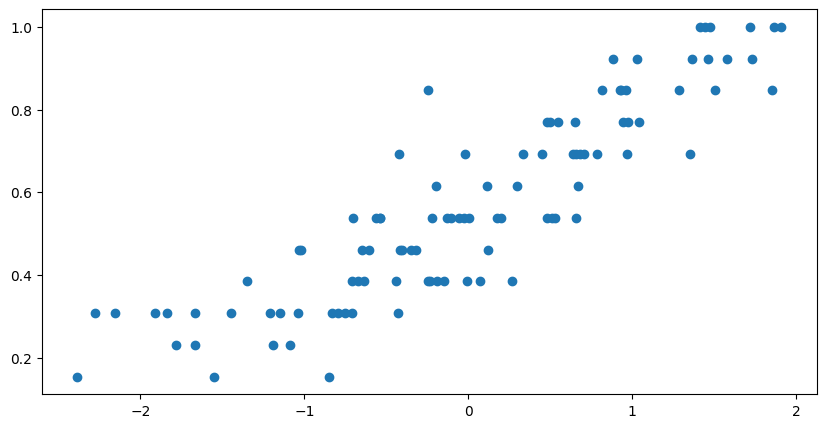

In [6]:
plt.scatter(abilities, preds.mean(axis = 1));

## Predicting abilities using the original model

If the question parameters were fixed and known, we could refit the model replacing the _sample sites_ for the questions with the actual fitted parameters. However, there is uncertainty in the question parameters.

Also, we do not wish to refit the model using the new batch of students: we do not want the new batch to influence the question parameters. Likewise, we do not want to refit the model using the combined set of students. Again, it would bias the question parameters.

(I am thinking about this exercise as a calibration-application exercise: the first student batch is used to calibrate the questions; then we just want to test student ability using these already calibrated questions.)

So the process will proceed as follows:
- We select a sample of posterior sample ids.
- For each of them, we fix the question sites to the sample values.
- We refit the model (which will affect the student performance scores).
- We keep a number (just a few) samples for each run.
- We stack all these samples.

In summary, we want to sample the distribution

$$\int p(s_i | \theta, R_1) p(\theta, R_0) d\theta $$

where 

- $R_i$ are the results of exams 0 and 1, 
- $p(\theta, R_0)$ is the posterior of the exam parameters as estimated in the previous fit, and
- $p(s_i | \theta, R_1)$ is the posterior of the student abilities for a fixed set of exam parameters $\theta$.

Obviously, if $p(\theta, R_0)$ was concentrated at $\theta_0$ the previous expression would reduce to $p(s_i | \theta_0, R_1)$, a much simpler distribution to estimate.

In [7]:
fixed_params = samples.copy()
del fixed_params['ability']

rng = np.random.default_rng()
sample_ids = rng.choice(fixed_params['difficulty'].shape[0], size=50, replace=False)

def get_posterior(sample_id):
    tmp = {k : v[sample_id] for k, v in fixed_params.items()}
    predictive_model = condition(model3pl, tmp)
    kernel_pred = NUTS(predictive_model)
    mcmc_pred   = MCMC(kernel_pred, num_warmup=1000, num_samples=100)

    mcmc_pred.run(
        rng_key, 
        scores = jnp.reshape(preds, (-1)),
        n_students = preds.shape[0],
        n_questions = preds.shape[1])
    
    return mcmc_pred.get_samples()['ability']

res = [get_posterior(sample_id) for sample_id in sample_ids]

sample: 100%|██████████| 1100/1100 [00:03<00:00, 339.72it/s, 7 steps of size 4.24e-01. acc. prob=0.87]


## Analysis of the results


/home/carlos/.local/share/virtualenvs/pyro-wwuZHPNO/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3652: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


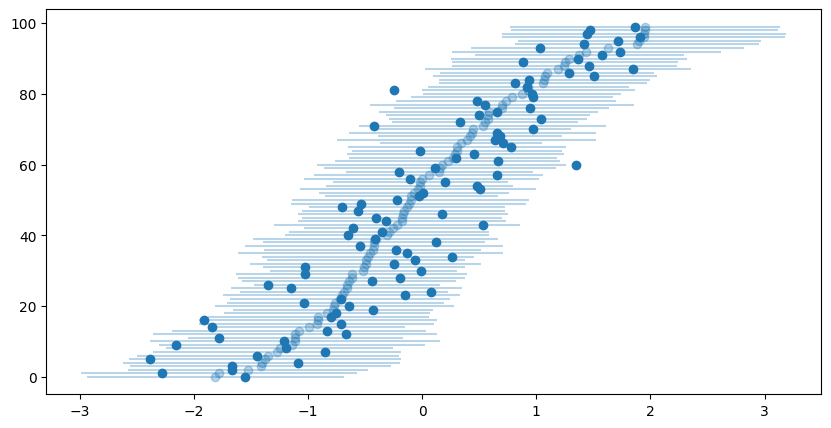

In [8]:
estimated_abilities = jnp.vstack(res)
order = np.argsort(estimated_abilities.mean(axis = 0))
tmp = [estimated_abilities[:,i] for i in order]
ordered_abilities = abilities[order]
pred_means = [x.mean() for x in tmp]
tmp_errors = [2 * np.std(x) for x in tmp]

tmp_x = range(len(tmp))

fig, ax = plt.subplots()
ax.errorbar(pred_means, tmp_x, xerr = tmp_errors, fmt = 'o', alpha = .3)
ax.scatter(ordered_abilities, tmp_x);

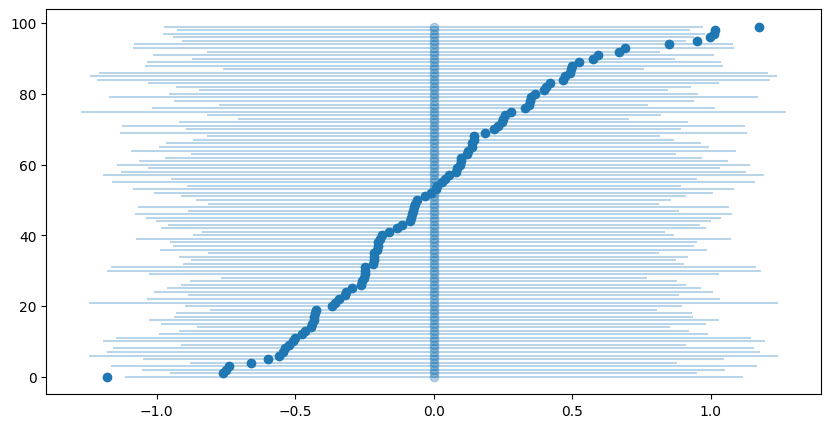

In [9]:
errors = pred_means - ordered_abilities

order = np.argsort(errors)
tmp = [estimated_abilities[:,i] for i in order]
errors = errors[order]
pred_means = [x.mean() for x in tmp]
tmp_errors = [2 * np.std(x) for x in tmp]

fig, ax = plt.subplots()
ax.errorbar(np.zeros(len(pred_means)), tmp_x, xerr = tmp_errors, fmt = 'o', alpha = .3)
ax.scatter(errors, tmp_x)
plt.show()